In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from portfolio_env_framework import *
from portfolio_env_with_tcost import *
import random
import torch
import numpy.typing as npt

In [398]:
class BasicDataManager(AbstractPortfolioEnvWithTCost):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+2), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('100_random_sample_tickers.csv')
        
        tickers = df.TICKER.unique()


        df = df.loc[df['TICKER'].isin(pd.Series(tickers).sample(n = 100, random_state = 1))]
        
        

        # create stock array
        pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
        stock_array = pivot_price_df.values.astype(float)
        
        # adjust for stock splits
        pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
        facpr_array = pivot_facpr_df.values.astype(float)
        self.stock_array = stock_array * (1+facpr_array).cumprod(axis=0)
        self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))
    
        normal_ret = pivot_price_df.pct_change().iloc[1:, :]


        self.tickers = df.TICKER.unique()
        self.times = df.date.unique()[100:]
    
        
    
        # read index data and compute volatilities
        daily_return = normal_ret.mean(axis = 1)
        vol_20 = daily_return.rolling(20).std()
        vol_60 = daily_return.rolling(60).std()
        self.vol_20 = vol_20[self.times].values
        self.vol_60 = vol_60[self.times].values
        
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix = vix_df.loc[self.times].vix.values
        
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)

        #get news sentiment data
        means_df = pd.read_csv('./news_sentiment_data_5.csv')
        means_df['Date'] = pd.to_datetime(means_df['Date'], errors='coerce')

        #filter date range
        means_df = means_df[(means_df.Date.dt.year >= 2010) & (means_df.Date.dt.year < 2015)]
        means_df = means_df.loc[means_df['Ticker'].isin(self.tickers)]

        #pivot to create an array that's easier to work with
        news_sentiment_array = means_df.pivot(index="Date", columns="Ticker", values="sentiment_embedding")
        
        #reindex the dataframe so that missing times are filled properly
        news_sentiment_array = news_sentiment_array.reindex(self.times).fillna(0)
        no_sentiment_tickers = list(set(self.tickers) - set(news_sentiment_array.columns.values))

        news_sentiment_array[[no_sentiment_tickers]] = 0
        self.news_sentiment_array = news_sentiment_array
       

        return len(self.times)-100 - 1, len(self.tickers)
    
    def get_state(self) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        
        s = np.zeros((self.universe_size+1, 100+2))
        s[:, 0] = self.w
        s[:-1, 1:-1] = self.ret[self.t:self.t+100, :].T
        s[:-1, -1] = self.news_sentiment_array.loc[self.times[self.t+100-1]].values
        s[-1, 1] = self.vol_20[self.t]
        s[-1, 2] = self.vol_20[self.t] / self.vol_60[self.t]
        s[-1, 3] = self.vix[self.t]
        
        return s

    def get_prices(self) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_array[self.t+100, :].flatten(), 1.0)

In [399]:
class DifferentialSharpeRatioReward(AbstractRewardManager):
    def __init__(self, eta: float = 1/252):
        self.eta = eta
        self.initialize_reward()

    def initialize_reward(self):
        self.A, self.B = 0.0, 0.0

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        R = np.log(new_port_val / old_port_val)
        dA = R - self.A
        dB = R ** 2 - self.B
        if self.B - self.A ** 2 == 0:
            D = 0
        else:
            D = (self.B * dA - 0.5 * self.A * dB) / (self.B - self.A ** 2) ** (3 / 2)
        self.A += self.eta * dA
        self.B += self.eta * dB
        return D

In [400]:
# Parallel environments
vec_env = make_vec_env(BasicDataManager, n_envs=4)

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework_full_news")

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3309946843.py:24: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


(1158, 92)


/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3309946843.py:24: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


(1158, 92)


/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3309946843.py:24: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


(1158, 92)


/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3309946843.py:24: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


(1158, 92)
Using cpu device


ValueError: could not broadcast input array from shape (92,) into shape (100,)

In [394]:
env = BasicDataManager()
obs, _ = env.reset()

port_val = [1.0]
eq_pf_val = [1.0]
actions = []
ys = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    port_val.append(info['port_val'])

    eq_pf_val.append(eq_pf_val[-1] * (1 + env.idx_df[env.idx_df.index == env.times[env.t]].vwretd.values[0]))
    if terminated:
        break

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3567216809.py:24: RuntimeWarning: invalid value encountered in log
  self.ret = np.nan_to_num(np.log(1 + np.diff(self.stock_array, axis=0) / self.stock_array[:-1, :]))


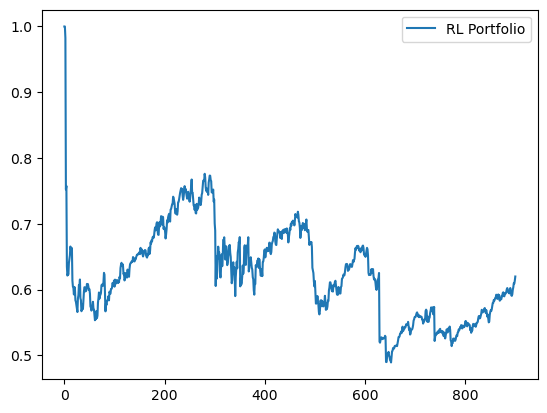

In [397]:
plt.plot(np.array(port_val), label='RL Portfolio')
# plt.plot(np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [2]:
df = pd.read_csv('crsp_full_2010_2024.csv', dtype='string')
    
# convert datatypes
df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR', 'vwretd']]
df.date = pd.to_datetime(df.date)
df.FACPR = df.FACPR.fillna('0.0')
df.astype({
    'PRC': float,
    'VOL': float,
    'ASKHI': float,
    'BIDLO': float,
    'FACPR': float,
    'vwretd': float
})

# drop duplicates and nans
df = df.drop_duplicates(subset=['date', 'TICKER'])
df.dropna(inplace=True)

# only include stocks that are present in all dates
ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
def is_max_val_count(ticker: str) -> bool:
  return ticker_ok[ticker]
ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
df = df[ok]
df = df[(df.date.dt.year >= 2010) & (df.date.dt.year < 2015)]

In [3]:
import random
tickers = df['TICKER'].unique()
df_reduced = df.loc[df['TICKER'].isin(pd.Series(tickers).sample(n = 100, random_state = 1))]

In [4]:
df_reduced.to_csv('100_random_sample_tickers.csv')

In [48]:
idx_df = df_reduced[['date', 'TICKER', 'vwretd', 'PRC']].copy()
idx_df.date = pd.to_datetime(idx_df.date)
idx_df['PRC'] = idx_df['PRC'].astype(float)
idx_df['weights'] = idx_df.groupby('date')['PRC'].transform(lambda x: x / x.sum())

In [49]:
idx_df['ticker_ret'] = .groupby(['TICKER'])['PRC'].transform(pd.Series.pct_change)

In [50]:
idx_df['ticker_ret']

114705     NaN
114706     NaN
114707     NaN
114708     NaN
114709     NaN
            ..
15786129   NaN
15786130   NaN
15786131   NaN
15786132   NaN
15786133   NaN
Name: ticker_ret, Length: 125800, dtype: float64

In [27]:
idx_df['vwretd']

114705       0.017123
114706       0.003374
114707       0.002046
114708       0.002860
114709       0.004173
              ...    
15786129     0.000579
15786130     0.003668
15786131     0.001242
15786132    -0.004285
15786133    -0.008784
Name: vwretd, Length: 125800, dtype: string

In [28]:
idx_df['vwretd'] = idx_df['vwretd'].astype(float)
idx_df['weights'] = idx_df.groupby('date')['PRC'].transform(lambda x: x / x.sum())
idx_df['pf_returns'] = (idx_df['weights'] * idx_df['vwretd']) + 1
idx_df['daily_ret'] = idx_df.groupby('date')['pf_returns'].transform("mean")

In [29]:
idx_df['pf_returns']

114705      1.000101
114706      1.000020
114707      1.000012
114708      1.000017
114709      1.000024
              ...   
15786129    1.000004
15786130    1.000023
15786131    1.000008
15786132    0.999973
15786133    0.999945
Name: pf_returns, Length: 125800, dtype: float64

In [30]:
idx_df['daily_ret']

114705      1.000171
114706      1.000034
114707      1.000020
114708      1.000029
114709      1.000042
              ...   
15786129    1.000006
15786130    1.000037
15786131    1.000012
15786132    0.999957
15786133    0.999912
Name: daily_ret, Length: 125800, dtype: float64

In [31]:
idx_df['vol_20'] = idx_df.daily_ret.rolling(20).std()
idx_df['vol_60'] = idx_df.daily_ret.rolling(60).std()

In [32]:
idx_df['vol_60']

114705           NaN
114706           NaN
114707           NaN
114708           NaN
114709           NaN
              ...   
15786129    0.000091
15786130    0.000089
15786131    0.000089
15786132    0.000089
15786133    0.000089
Name: vol_60, Length: 125800, dtype: float64

In [53]:
# create stock array
stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
# adjust for stock splits
facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
stock_df = stock_df * (1+facpr_df).cumprod(axis=0)
# assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
ret = stock_df.pct_change().iloc[1:, :] + 1

In [88]:
ret.isnull().any().sum()

0

In [59]:
daily_return = ret.mean(axis = 1).pct_change().fillna(0)

In [60]:
daily_return

date
2010-01-05    0.000000
2010-01-06   -0.013445
2010-01-07    0.005845
2010-01-08   -0.000507
2010-01-11   -0.005046
                ...   
2014-12-24   -0.023703
2014-12-26    0.004446
2014-12-29    0.008910
2014-12-30   -0.009182
2014-12-31    0.007279
Length: 1257, dtype: float64

In [73]:
vol_20 = daily_return.rolling(20).std()
vol_20

date
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
2010-01-11         NaN
                ...   
2014-12-24    0.016624
2014-12-26    0.016614
2014-12-29    0.015305
2014-12-30    0.015498
2014-12-31    0.014611
Length: 1257, dtype: float64

In [69]:
daily_return.rolling(60).std().fi

array([       nan,        nan,        nan, ..., 0.01332036, 0.01335531,
       0.01337574])

In [74]:
times = df_reduced.date.unique()[1:]

In [76]:
vol_20[times[0 + 100 - 1]]

0.030529584013301223

In [96]:
vol_20[times[100:]].values

array([0.03186812, 0.03108743, 0.03171531, ..., 0.01530471, 0.01549751,
       0.01461119])

In [122]:
s = np.zeros((100+1, 100+2))
        
s[:, 0] = np.zeros(101)
s[1:, :-2] = ret[0:0+100, :].T

InvalidIndexError: (slice(0, 100, None), slice(None, None, None))

In [230]:
means_df = pd.read_csv('./news_sentiment_data.csv')
means_df['Date'] = pd.to_datetime(means_df['Date'], errors='coerce')
means_df = means_df[(means_df.Date.dt.year >= 2010) & (means_df.Date.dt.year < 2015)]
means_df = means_df.loc[means_df['Ticker'].isin(tickers)]
news_sentiment_array = means_df.pivot(index="Date", columns="Ticker", values="sentiment_embedding")
news_sentiment_array = news_sentiment_array.reindex(pd.to_datetime(times)).fillna(0)
news_sentiment_array.loc['2010-10-18']

Ticker
ACN      0.000000
ADBE     0.000000
AIG      0.000000
AMT      0.000000
AVGO     0.000000
AXP      0.976186
BAC      0.000000
BK       0.000000
BLK      0.000000
BMY      0.932262
CAT      0.000000
CL       0.000000
CMCSA    0.000000
COF      0.000000
COP      0.000000
CVS      0.000000
DE       0.000000
DHR     -1.000000
DUK      0.000000
EMR      0.000000
FDX      0.000000
GD       0.208359
GILD     0.000000
HD       0.817121
INTU     0.000000
JNJ      0.000000
KO       0.999997
LLY     -0.886232
LMT      0.505338
LOW      0.000000
MA       1.000000
MCD      0.000000
MDT     -1.000000
MET      0.000000
MMM     -1.000000
MO       0.000000
MRK      0.590024
MS      -0.374152
NVDA     0.000000
ORCL     0.000000
PEP      0.942265
PG       0.000000
QCOM     0.000000
SO       0.991314
SPG      0.000000
TMO      0.996130
TXN      0.000000
USB      1.000000
VZ       0.000000
WFC      0.000000
Name: 2010-10-18 00:00:00, dtype: float64

In [212]:
times

<DatetimeArray>
['2010-01-05 00:00:00', '2010-01-06 00:00:00', '2010-01-07 00:00:00',
 '2010-01-08 00:00:00', '2010-01-11 00:00:00', '2010-01-12 00:00:00',
 '2010-01-13 00:00:00', '2010-01-14 00:00:00', '2010-01-15 00:00:00',
 '2010-01-19 00:00:00',
 ...
 '2014-12-17 00:00:00', '2014-12-18 00:00:00', '2014-12-19 00:00:00',
 '2014-12-22 00:00:00', '2014-12-23 00:00:00', '2014-12-24 00:00:00',
 '2014-12-26 00:00:00', '2014-12-29 00:00:00', '2014-12-30 00:00:00',
 '2014-12-31 00:00:00']
Length: 1257, dtype: datetime64[ns]

In [213]:
no_sentiment_tickers = list(set(tickers) - set(news_sentiment_array.columns.values))
news_sentiment_array[[no_sentiment_tickers]] = 0


/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3840928974.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  news_sentiment_array[[no_sentiment_tickers]] = 0
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3840928974.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  news_sentiment_array[[no_sentiment_tickers]] = 0
/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3840928974.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [214]:
news_sentiment_array

Ticker,Date,ACN,ADBE,AIG,AMT,AVGO,AXP,BAC,BK,BLK,...,PODD,FRI,FXD,HUM,MKC,MYE,AUBN,SLB,PSP,GHM
0,2010-01-05,0.000008,0.987103,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2010-01-06,0.000000,0.000000,0.0,0.0,0.0,0.637422,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,2010-01-07,-1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.870066,...,0,0,0,0,0,0,0,0,0,0
3,2010-01-08,0.000000,0.000000,0.0,0.0,0.0,0.348962,0.000000,0.0,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,2010-01-11,0.619096,0.000000,0.0,0.0,0.0,-0.982951,0.000000,0.0,1.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2014-12-24,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.035201,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1253,2014-12-26,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1254,2014-12-29,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.027578,...,0,0,0,0,0,0,0,0,0,0
1255,2014-12-30,0.825447,0.000000,0.0,0.0,-1.0,0.000000,0.896171,0.0,0.050379,...,0,0,0,0,0,0,0,0,0,0


In [216]:
news_sentiment_array.loc[times[8]]

KeyError: Timestamp('2010-01-15 00:00:00')

In [156]:
times.index('20')

<DatetimeArray>
['2010-01-05 00:00:00', '2010-01-06 00:00:00', '2010-01-07 00:00:00',
 '2010-01-08 00:00:00', '2010-01-11 00:00:00', '2010-01-12 00:00:00',
 '2010-01-13 00:00:00', '2010-01-14 00:00:00', '2010-01-15 00:00:00',
 '2010-01-19 00:00:00',
 ...
 '2014-12-17 00:00:00', '2014-12-18 00:00:00', '2014-12-19 00:00:00',
 '2014-12-22 00:00:00', '2014-12-23 00:00:00', '2014-12-24 00:00:00',
 '2014-12-26 00:00:00', '2014-12-29 00:00:00', '2014-12-30 00:00:00',
 '2014-12-31 00:00:00']
Length: 1257, dtype: datetime64[ns]

In [142]:
news_sentiment_array

Ticker,ACN,ADBE,AIG,AMT,AVGO,AXP,BAC,BK,BLK,BMY,...,PODD,FRI,FXD,HUM,MKC,MYE,AUBN,SLB,PSP,GHM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-03,0.999632,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-04,0.000000,0.000000,0.0,0.0,0.0,-0.927109,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05,0.000008,0.987103,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.000000,0.424215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-06,0.000000,0.000000,0.0,0.0,0.0,0.637422,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-07,-1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.870066,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-28,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-29,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.027578,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
full_times = pd.date_range(start = times[0], end = times[-1], freq='D')

In [191]:
full_times[286]

Timestamp('2010-10-18 00:00:00')

In [218]:
news_sentiment_array_test = news_sentiment_array.set_index('Date').reindex(pd.to_datetime(times)).fillna(0)

In [219]:
news_sentiment_array_test

Ticker,ACN,ADBE,AIG,AMT,AVGO,AXP,BAC,BK,BLK,BMY,...,PODD,FRI,FXD,HUM,MKC,MYE,AUBN,SLB,PSP,GHM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.000008,0.987103,0.0,0.0,0.0,-1.000000,0.000000,0.0,0.000000,0.424215,...,0,0,0,0,0,0,0,0,0,0
2010-01-06,0.000000,0.000000,0.0,0.0,0.0,0.637422,0.000000,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2010-01-07,-1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.870066,0.000000,...,0,0,0,0,0,0,0,0,0,0
2010-01-08,0.000000,0.000000,0.0,0.0,0.0,0.348962,0.000000,0.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2010-01-11,0.619096,0.000000,0.0,0.0,0.0,-0.982951,0.000000,0.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.035201,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2014-12-26,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2014-12-29,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.027578,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [223]:
news_sentiment_array_test.loc['2010-10-18']

Ticker
ACN     0.0
ADBE    0.0
AIG     0.0
AMT     0.0
AVGO    0.0
       ... 
MYE     0.0
AUBN    0.0
SLB     0.0
PSP     0.0
GHM     0.0
Name: 2010-10-18 00:00:00, Length: 2173, dtype: float64

In [210]:
news_sentiment_array.index

RangeIndex(start=0, stop=1822, step=1)

In [292]:
# read SNP data
df = pd.read_csv('100_random_sample_tickers.csv')

tickers = df.TICKER.unique()

df = df.loc[df['TICKER'].isin(pd.Series(tickers).sample(n = 100, random_state = 1))]

tickers = df.TICKER.unique()

times = df.date.unique()[100:]

# create stock array
pivot_price_df = df.pivot(index='date', columns='TICKER', values='PRC')
stock_array = pivot_price_df.values.astype(float)
stock_array 

array([[ 16.65,  57.17,  28.4 , ...,  52.54,  52.73,  27.7 ],
       [ 16.13,  57.81,  28.37, ...,  52.77,  52.93,  27.56],
       [ 16.97,  57.76,  28.38, ...,  52.9 ,  53.85,  27.21],
       ...,
       [ 15.82,  60.95,  25.74, ..., 108.37,  66.85,  71.8 ],
       [ 15.85,  60.67,  25.94, ..., 107.82,  66.41,  71.65],
       [ 15.79,  60.93,  25.83, ..., 106.82,  65.73,  70.1 ]])

In [293]:
# adjust for stock splits
pivot_facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR')
facpr_array = pivot_facpr_df.values.astype(float)
stock_array = stock_array * (1+facpr_array).cumprod(axis=0)
ret = np.log(1 + np.diff(stock_array, axis=0) / stock_array[:-1, :])
ret

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/3174938607.py:5: RuntimeWarning: invalid value encountered in log
  ret = np.log(1 + np.diff(stock_array, axis=0) / stock_array[:-1, :])


array([[-0.03172932,  0.01113249, -0.0010569 , ...,  0.00436806,
         0.00378573, -0.00506697],
       [ 0.05076619, -0.00086528,  0.00035242, ...,  0.00246049,
         0.01723212, -0.01278089],
       [-0.02144216, -0.00485943,  0.00070447, ...,  0.01221246,
        -0.01270808,  0.01567945],
       ...,
       [ 0.        , -0.00114782, -0.00619677, ...,  0.00203122,
         0.00750754, -0.01011579],
       [ 0.00189454, -0.00460451,  0.00773998, ..., -0.00508813,
        -0.00660366, -0.00209132],
       [-0.00379267,  0.00427632, -0.00424957, ..., -0.009318  ,
        -0.01029221, -0.02187036]])

In [294]:
pivot_price_df

TICKER,AA,AAXJ,AB,ADTN,AIN,ARE,ASX,ATRI,AZO,BAB,...,TBBK,TDC,TIPZ,UFCS,UMBF,USAP,USEG,VIS,VMC,WPC
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,16.65,57.17,28.40,22.70,23.16,63.55,4.65,155.85001,158.03000,24.33,...,7.43,30.87,51.4300,18.48,39.42,19.61,6.18,52.5400,52.73,27.70
2010-01-05,16.13,57.81,28.37,22.97,22.85,62.88,4.77,155.72000,156.71001,24.33,...,7.14,30.99,51.6800,17.67,38.67,19.58,6.17,52.7700,52.93,27.56
2010-01-06,16.97,57.76,28.38,22.93,22.36,62.55,4.73,158.99001,155.24001,24.19,...,7.15,30.65,51.5700,17.49,38.34,19.47,6.76,52.9000,53.85,27.21
2010-01-07,16.61,57.48,28.40,23.50,22.45,63.13,5.07,164.50000,157.30000,24.21,...,7.28,30.30,51.7100,17.62,39.17,19.33,6.66,53.5500,53.17,27.64
2010-01-08,17.02,57.71,29.27,23.33,22.77,62.92,4.98,163.53999,155.28000,24.25,...,7.20,30.79,51.7293,17.64,39.34,19.43,6.64,54.2600,52.65,27.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,15.77,60.37,25.74,21.99,37.46,89.23,6.27,338.89999,617.42999,30.31,...,10.66,45.22,56.5000,29.04,57.05,26.05,1.56,108.0100,66.27,72.47
2014-12-26,15.82,61.02,25.90,22.16,37.64,89.78,6.21,346.17001,618.76001,30.22,...,10.74,44.97,56.6500,29.33,57.60,25.94,1.48,108.1501,66.35,72.53
2014-12-29,15.82,60.95,25.74,22.12,37.92,89.78,6.22,342.01999,624.48999,30.36,...,10.78,44.94,56.5800,29.47,58.21,25.85,1.42,108.3700,66.85,71.80


In [295]:
normal_ret = pivot_price_df.pct_change().iloc[1:, :]
normal_ret.mean(axis = 1)


date
2010-01-05   -0.000545
2010-01-06   -0.015961
2010-01-07   -0.013075
2010-01-08   -0.017440
2010-01-11   -0.019743
                ...   
2014-12-24    0.002106
2014-12-26    0.001900
2014-12-29   -0.001501
2014-12-30   -0.001289
2014-12-31   -0.003649
Length: 1257, dtype: float64

In [297]:

# read index data and compute volatilities
daily_return = normal_ret.mean(axis = 1)
vol_20 = daily_return.rolling(20).std()
vol_60 = daily_return.rolling(60).std()

In [298]:
daily_return[100]

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/4189850486.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_return[100]


-0.029605433867664094

In [299]:
vol_20[times]

date
2010-05-27    0.025275
2010-05-28    0.023850
2010-06-01    0.023763
2010-06-02    0.023871
2010-06-03    0.023835
                ...   
2014-12-24    0.016509
2014-12-26    0.016387
2014-12-29    0.015332
2014-12-30    0.013962
2014-12-31    0.013770
Length: 1158, dtype: float64

In [300]:
vol_20 = vol_20[times].values
vol_60 = vol_60[times].values

In [301]:
vol_20

array([0.02527474, 0.02384983, 0.02376348, ..., 0.0153318 , 0.01396171,
       0.01376987])

In [304]:

# get vix data
vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
    'Date': 'string',
    'vix': float
})
vix_df.Date = pd.to_datetime(vix_df.Date)
vix_df.set_index('Date', inplace=True)
vix = vix_df.loc[times].vix.values
vix.shape

(1158,)

In [303]:
num_time_periods = len(times)-100-1
universe_size = len(tickers)

In [305]:
#get news sentiment data
means_df = pd.read_csv('./news_sentiment_data_5.csv')
means_df['Date'] = pd.to_datetime(means_df['Date'], errors='coerce')
means_df = means_df[(means_df.Date.dt.year >= 2010) & (means_df.Date.dt.year < 2015)]
means_df = means_df.loc[means_df['Ticker'].isin(tickers)]
news_sentiment_array = means_df.pivot(index="Date", columns="Ticker", values="sentiment_embedding")
news_sentiment_array

Ticker,AA,AB,ADTN,AIN,ARE,ASX,ATRI,AZO,BAB,BAM,...,TAST,TBBK,TDC,UFCS,UMBF,USAP,USEG,VIS,VMC,WPC
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,-0.000442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.338841,NaN,NaN,NaN,0.979594,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.890501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.923550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999988
2014-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320197


In [306]:
news_sentiment_array.loc['2010-05-28']

Ticker
AA      0.333353
AB           NaN
ADTN         NaN
AIN          NaN
ARE          NaN
          ...   
USAP         NaN
USEG         NaN
VIS          NaN
VMC          NaN
WPC          NaN
Name: 2010-05-28 00:00:00, Length: 92, dtype: float64

In [307]:
news_sentiment_array = news_sentiment_array.reindex(pd.to_datetime(times)).fillna(0)
no_sentiment_tickers = list(set(tickers) - set(news_sentiment_array.columns.values))
news_sentiment_array[[no_sentiment_tickers]] = 0
news_sentiment_array

Ticker,AA,AB,ADTN,AIN,ARE,ASX,ATRI,AZO,BAB,BAM,...,VMC,WPC,MHF,DWX,AAXJ,TIPZ,PFI,EXC,IWV,PNF
2010-05-27,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0,0,0,0,0,0,0,0
2010-05-28,0.333353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0,0,0,0,0,0,0,0
2010-06-01,-0.150171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0,0,0,0,0,0,0,0
2010-06-02,-0.310713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0,0,0,0,0,0,0,0
2010-06-03,-0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030705,...,0.000000,0.962946,0,0,0,0,0,0,0,0
2014-12-26,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.999988,0,0,0,0,0,0,0,0
2014-12-29,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.320197,0,0,0,0,0,0,0,0
2014-12-30,0.572392,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,...,0.000000,0.000000,0,0,0,0,0,0,0,0


In [339]:
s = np.zeros((100+1, 100+2))
        
s[:, 0] = np.zeros(101)
s[:-1, 1:-1] = ret[0:100, :].T
s[:-1, -1] = news_sentiment_array.loc[times[0+100-1]].values
s[-1, 1] = vol_20[0]
s[-1, 2] = vol_20[0] / vol_60[0]
s[-1, 3] = vix[0]

In [340]:
s

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.17293243e-02,  5.07661871e-02, ...,
        -4.43459707e-03,  4.94248833e-02, -7.44048596e-01],
       [ 0.00000000e+00,  1.11324858e-02, -8.65276510e-04, ...,
        -1.98275008e-04,  5.00829648e-02,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  4.36806316e-03,  2.46049145e-03, ...,
         4.11633657e-03,  3.58375885e-02,  0.00000000e+00],
       [ 0.00000000e+00,  3.78573233e-03,  1.72321177e-02, ...,
         1.10832369e-02,  4.02607148e-02,  0.00000000e+00],
       [ 0.00000000e+00,  2.52747420e-02,  1.27579929e+00, ...,
         3.62976805e-03,  3.10210786e-02,  0.00000000e+00]])

In [336]:
ret[0:100, :]

array([[-0.03172932,  0.01113249, -0.0010569 , ...,  0.00436806,
         0.00378573, -0.00506697],
       [ 0.05076619, -0.00086528,  0.00035242, ...,  0.00246049,
         0.01723212, -0.01278089],
       [-0.02144216, -0.00485943,  0.00070447, ...,  0.01221246,
        -0.01270808,  0.01567945],
       ...,
       [ 0.01875892, -0.01495502, -0.00256082, ..., -0.00075122,
         0.00162239, -0.01228783],
       [-0.0044346 , -0.00019828,  0.01056669, ...,  0.00411634,
         0.01108324,  0.00362977],
       [ 0.04942488,  0.05008296,  0.05362837, ...,  0.03583759,
         0.04026071,  0.03102108]])

In [334]:
stock_array

array([[ 16.65,  57.17,  28.4 , ...,  52.54,  52.73,  27.7 ],
       [ 16.13,  57.81,  28.37, ...,  52.77,  52.93,  27.56],
       [ 16.97,  57.76,  28.38, ...,  52.9 ,  53.85,  27.21],
       ...,
       [ 15.82,  60.95,  25.74, ..., 108.37,  66.85,  71.8 ],
       [ 15.85,  60.67,  25.94, ..., 107.82,  66.41,  71.65],
       [ 15.79,  60.93,  25.83, ..., 106.82,  65.73,  70.1 ]])

In [348]:
ret_log = np.log(1 + np.diff(stock_array, axis=0) / stock_array[:-1, :])

/var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/ipykernel_7424/2152737725.py:1: RuntimeWarning: invalid value encountered in log
  ret_log = np.log(1 + np.diff(stock_array, axis=0) / stock_array[:-1, :])


In [349]:
np.isnan(ret_log).any()

True